<img style="float: left; padding-right: 5px; width: 300px" 
src="https://github.com/dianagold/Ec1152_diana/blob/master/econlogo.png?raw=true"> <br/><br/><br/>
# Ec 1152 Using big data to solve economic and social problems
### Section 3: Regression Discontinuity 

**Harvard University** - Spring 2019 <br/>
**Instructor**: Prof. Raj Chetty <br/>
**Head TF**: Greg Bruich <br/>
**TF**: Diana Goldemberg

In [174]:
import pandas as pd
import numpy as np
import patsy
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

## First Look At The Data

Simplified dataset from Lindo, Sanders and Oreopoulos (2010)

In [182]:
# Assuming that you downloaded the dataset to the same dir from where you are running the notebook 
probation_data_file = './section3_probation.csv'
probation_df = pd.read_csv(probation_data_file, low_memory=False)
print(probation_df.describe())

       age_at_entry       gradin4       english          male   left_school  \
count  30017.000000  30017.000000  30017.000000  30017.000000  30017.000000   
mean      18.768098      0.446647      0.726522      0.386581      0.053137   
std        0.700307      0.497154      0.445752      0.486974      0.224309   
min       17.000000      0.000000      0.000000      0.000000      0.000000   
25%       18.000000      0.000000      0.000000      0.000000      0.000000   
50%       19.000000      0.000000      1.000000      0.000000      0.000000   
75%       19.000000      1.000000      1.000000      1.000000      0.000000   
max       21.000000      1.000000      1.000000      1.000000      1.000000   

        hsgrade_pct           GPA  
count  30017.000000  30017.000000  
mean      48.386914      2.481687  
std       28.857860      0.898434  
min        1.000000      0.000000  
25%       23.000000      1.880000  
50%       48.000000      2.550000  
75%       73.000000      3.160000  


## Variable Creation
Create X, our running variable, GPA centered around the cut-off 1.6 <br/>
Create T, treatement indicator, for being below probation threshold <br/>
Create XT, an interaction term 

In [176]:
probation_df = probation_df.assign(X= lambda x: x['GPA'] - 1.6,
                                   T= lambda x: (x['X']<0).astype('int'),
                                   XT= lambda x: x['X']*x['T'])
probation_df.head()

,age_at_entry,gradin4,english,male,left_school,hsgrade_pct,GPA,X,T,XT
0,19,0,1,0,0,94,3.74,2.14,0,0.0
1,18,1,1,1,0,65,2.05,0.45,0,0.0
2,18,0,1,1,1,39,2.28,0.68,0,0.0
3,19,1,1,0,0,72,3.88,2.28,0,0.0
4,18,1,0,1,0,22,3.33,1.73,0,0.0


### Estimate RD

In [177]:
# First, sets the window (bandwidth)
window_df = probation_df[(probation_df['X'] >= -1.2) & (probation_df['X'] <= 1.2)]

# Remember that only the coefficient on T has a causal interpretation
formula = 'gradin4 ~ T + X + XT'
aux_y, aux_X = patsy.dmatrices(formula, window_df, return_type='dataframe')
resrlm = sm.RLM(aux_y, aux_X).fit()
print(resrlm.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                gradin4   No. Observations:                17670
Model:                            RLM   Df Residuals:                    17666
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 24 Feb 2019                                         
Time:                        23:36:33                                         
No. Iterations:                     9                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2813      0.009     33.054      0.0

### Bin scatter
Equivalent in Stata that we wish to construct:<br/>
"binscatter gradin4 X if inrange(X, -1.2, 1.2), rd(0) nq(40)" <br/>
Note that it requires the previous step for bandwidth setup and linear fits

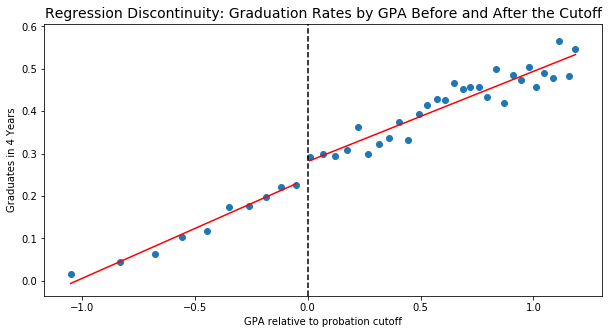

In [179]:
# Function to get the points for the scatter (x mean, y mean)
def prep_binscatter(x, y, n_bins):
    # Sorts data based on x
    if np.any(np.diff(x) < 0):
        argsort = np.argsort(x)
        x = x[argsort]
        y = y[argsort]
    x_data = x
    y_data = y   
    # Creates bins
    if x_data.ndim == 1:
        x_data = x_data[:, None]
    bin_edges = np.linspace(0, len(y), n_bins + 1).astype(int)
    assert len(bin_edges) == n_bins + 1
    bins = [slice(bin_edges[i], bin_edges[i + 1]) for i in range(len(bin_edges) - 1)]
    assert len(bins) == n_bins
    # Prepares outputs
    x_means = [np.mean(x_data[bin_]) for bin_ in bins]
    y_means = [np.mean(y_data[bin_]) for bin_ in bins]
    return x_means, y_means


# Here you should customize according to your dataset
x=window_df['X']
y=window_df['gradin4']

# Use the fuction to store points to scatter in two lists
x_means, y_means = prep_binscatter(np.asarray(x), np.asarray(y), n_bins=40)

# Calculate the linear predictions to plot
x_means_left = list(filter(lambda x: x<0, x_means))
x_means_right = list(filter(lambda x: x>0, x_means))
y_hat_left  = (resrlm.params[0]+resrlm.params[1]) + (resrlm.params[2]+resrlm.params[3])*np.asarray(x_means_left)
y_hat_right = resrlm.params[0] + resrlm.params[2]*np.asarray(x_means_right)
y_hat = [*y_hat_left, *y_hat_right] 
n = len(x_means_left)


# Plot the binscatter
fig, rdplot = plt.subplots(1, 1, figsize=(10, 5))
rdplot.scatter(x_means, y_means)
rdplot.set_xlabel('GPA relative to probation cutoff')
rdplot.set_ylabel('Graduates in 4 Years')
rdplot.set_title("Regression Discontinuity: Graduation Rates by GPA Before and After the Cutoff", fontsize="14")
rdplot.plot(x_means[0:n], y_hat[0:n], '-', color="r")
rdplot.plot(x_means[n:], y_hat[n:], '-', color="r")
rdplot.axvline(x=-0,color="black", linestyle="--")
plt.show()